#    This notebook is an exploration of Cambridge, Massachusettes bike data
#### Part 1: A brief look at the demographics of bikers of Cambridge and how biking in Cambridge has changed over time
#### Part 2: A more in depth look at crashes involving bicycles over time. 

###### Begun 10/28/19
   ###### Note: This is a work in progress and is expected to be completed no later than 12/7/2019

### Log of data included in this project
#### - transport_data: Labor Force Commuting Mode Split: 1990, 2000, 2006 - 2010, and 2012 - 2016. From data.cambridgema.gov: "This data set compares 1990, 2000, 2006 - 2010, and 2012-16 Journey to Work data, outlining the modes of commuting for the Labor Force of the City of Cambridge, regardless of workplace location. The data set originates from three sources: 1990 Journey to Work data supplied to the Massachusetts Central Transportation Planning Staff by the Census Bureau, a special tabulation of 2000 Decennial Census data - the 2000 Census Transportation Planning Products (CTPP), and the two most recent versions of the CTPP compiled from the American Community Survey. The Cambridge Labor Force consist of all Cambridge residents who work or who are currently seeking work, regardless of workplace location." https://data.cambridgema.gov/Transportation-Planning/Labor-Force-Commuting-Mode-Split-1990-2000-2006-20/8acn-zxjt
#### - new_crash_data: List of crashes involving motor vehicles, bicycles and/or pedestrians reported in the City of Cambridge since 2015. https://data.cambridgema.gov/Public-Safety/Police-Department-Crash-Data-Updated/gb5w-yva3
#### - nbr_data: Blockgroup data from the 2013-2017 American Community Survey was recompiled by the Cambridge Community Development Department to align with approximate neighborhood boundaries. Categories include: Total Population, Language Spoken at Home by Population 5 and Older, Educational Attainment by Population 25 and Older, Means of Commute for Resident Workers, Vehicles Owned by Household, Per Capita Income, and Poverty Rates. https://data.cambridgema.gov/Neighborhood-Census-Data/American-Community-Survey-2013-17-Estimates-by-Nei/m9gy-vc6p
#### - broad_bike_count: The “Eco-Totem” counter (made by the Montreal-based company Eco-Counter) counts cyclists via in-ground loop detectors embedded under the pavement of Broadway near Kendall Square. https://data.cambridgema.gov/dataset/Eco-Totem-Broadway-Bicycle-Count/q8v9-mcfg


In [79]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
from bs4 import BeautifulSoup
import requests
import math

In [3]:
#This cell imports all datasets used in this data exploration
trans_data = pd.read_csv('Labor_Force_Commuting.csv')

new_crash_data = pd.read_csv('Police_crash_data.csv')

nbr_data = pd.read_csv('Neighborhood_economic_data.csv')

broad_bike_count = pd.read_csv('Broadway_bike_count.csv')

broad_bike_count.head()


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (81,110,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DateTime,Day,Date,Time,Total,Westbound,Eastbound
0,06/24/2015 12:00:00 AM,Wednesday,06/24/2015,00:00:00,4,1,3
1,06/24/2015 12:15:00 AM,Wednesday,06/24/2015,00:15:00,3,3,0
2,06/24/2015 12:30:00 AM,Wednesday,06/24/2015,00:30:00,4,3,1
3,06/24/2015 12:45:00 AM,Wednesday,06/24/2015,00:45:00,2,2,0
4,06/24/2015 01:00:00 AM,Wednesday,06/24/2015,01:00:00,2,2,0


In [24]:
# this cell webscrapes monthly weather data for Cambridge
page = requests.get("https://www.areavibes.com/cambridge-ma/weather/")
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find(class_ = "av-default").get_text()

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
              'August', 'September', 'October', 'November', 'December']
num_month_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

#find each month in the scraped table and collect the corresponding temperature and precipitation data
max_temp = []
min_temp = []
avg_temp = []
avg_precip = []

for month in month_list:
    start = table.index(month)+len(month)
    min_temp.append(int(table[start:start+2]))
    max_temp.append(int(table[start+4:start+6]))
    avg_temp.append(int(table[start+8:start+10]))
    avg_precip.append(float(table[start+12:start+15]))

monthly_weather = pd.DataFrame({"Month": month_list, "Month Number": num_month_list, "Min Temp": min_temp, "Max Temp": max_temp, "Avg Temp": avg_temp, "Avg Precipitation": avg_precip})
monthly_weather.head()
        

,Month,Month Number,Min Temp,Max Temp,Avg Temp,Avg Precipitation
0,January,01,23,40,31,3.2
1,February,02,22,41,31,3.2
2,March,03,29,48,38,3.8
3,April,04,40,61,49,3.7
4,May,05,50,69,58,3.8


## Part 1: Biker demographics and changes over time

In [25]:
#begin investigation by comparing citywide data by year (trans_data also includes data broken down by )
city_trans_data  = trans_data.loc[trans_data['Census Tract'] == 'Citywide']
city_trans_data.head()


,Census Tract,Year,Population,Total Laborforce,% of Total Laborforce,Drove Alone,Carpool,Public Transit,Bike,Walk,Other Mode,Work at Home
0,Citywide,1990,95802,52355,100.0,37.7,7.5,23.4,2.9,24.2,0.9,3.4
1,Citywide,2000,101355,54979,100.0,35.3,5.2,24.9,3.9,24.3,1.1,5.3
2,Citywide,2006-2010,103506,56910,100.0,30.7,4.6,28.1,6.8,22.7,1.1,6.1
131,Citywide,2012-2016,108755,61930,100.0,28.2,3.5,28.9,7.0,24.6,1.0,6.8


### Comparision of the population of Cambridge vs different commute methods

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

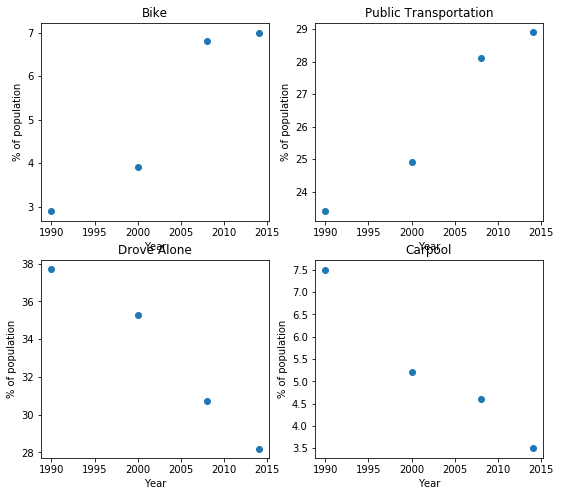

In [6]:
rcParams['figure.figsize'] = 9, 8
years = [1990, 2000, 2008, 2014]
plt.subplot(2,2,1)
plt.scatter(years,city_trans_data['Bike'])
plt.xlabel('Year')
plt.ylabel('% of population')
plt.title('Bike')
plt.subplot(2,2,2)
plt.scatter(years, city_trans_data['Public Transit'])
plt.title('Public Transportation')
plt.xlabel('Year')
plt.ylabel('% of population')
plt.subplot(2,2,3)
plt.scatter(years, city_trans_data['Drove Alone'])
plt.title('Drove Alone')
plt.xlabel('Year')
plt.ylabel('% of population')
plt.subplot(2,2,4)
plt.scatter(years,city_trans_data['Carpool'])
plt.title('Carpool')
plt.xlabel('Year')
plt.ylabel('% of population')
plt.tight_layout

#### As the population of Cambridge has grown, the percentage of the population commuting via bicycle and public transit has also increased. The percentage of Cambridge residents carpooling and driving by themselves to work has decreased. Overall Cambridge residents are commuting less by car and more by alternate means of transportation than they were 20, 10, and even 5 years ago.

In [7]:
#plot the number of bikers each day 
#broad_bike_count breaks down num of bikers into 15 min increments, want to switch to days
pd.to_datetime(broad_bike_count['Date'])
broad_bike_count = broad_bike_count.sort_values(by='Date')
date_col = broad_bike_count['Date']
count_col = broad_bike_count['Total']

prev_date = date_col.iloc[1]
prev_count = 0
date_list = []
count_list = []
for i in range(len(date_col)):
    curr_date = date_col.iloc[i]
    curr_count = int(count_col.iloc[i])
    if curr_date == prev_date:
        curr_count += prev_count
    else:
        date_list.append(prev_date)
        count_list.append(prev_count)
    prev_date = curr_date
    prev_count = curr_count

daily_bike_count = pd.DataFrame({'Date':date_list, 'Count': count_list})
daily_bike_count.head(5)

,Date,Count
0,01/01/2016,157
1,01/01/2017,124
2,01/01/2018,40
3,01/01/2019,169
4,01/02/2016,192


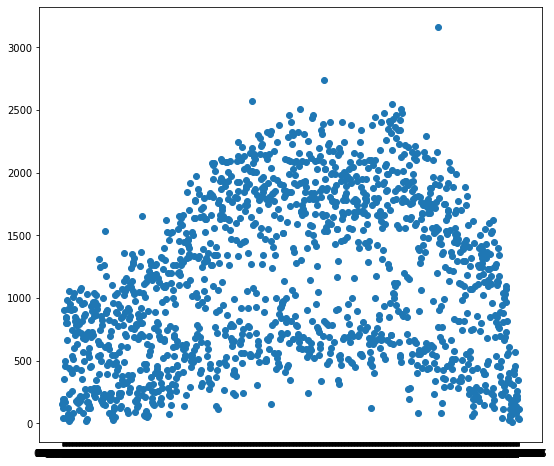

In [8]:
plt.scatter(daily_bike_count['Date'], daily_bike_count['Count'])

In [21]:
#this is a lot of data points, want to switch to monthly count instead

date_col = daily_bike_count['Date']
count_col = daily_bike_count['Count']

count_list = []
month_count_dict ={}

for i in range(len(date_col)):
    
    count = int(count_col.iloc[i])
    month_year = str(date_col.iloc[i][:2]) + str(date_col.iloc[i][6:])
    
    if month_year in month_count_dict:
        month_count_dict[month_year] += count
    else:
        month_count_dict[month_year] = count

#remove 06/2015 because counter started mid way through this month
month_count_dict.pop('062015')
        
month_years = list(month_count_dict.keys())
months = []
years = []
for i in month_years:
    months.append(i[0:2])
    years.append(i[2:])
count = list(month_count_dict.values())

monthly_bike_count = pd.DataFrame({'Month': months, 'Years': years, 'Count': count})
monthly_bike_count.head()

,Month,Years,Count
0,01,2016,17526
1,01,2017,17450
2,01,2018,11837
3,01,2019,18537
4,02,2016,18331


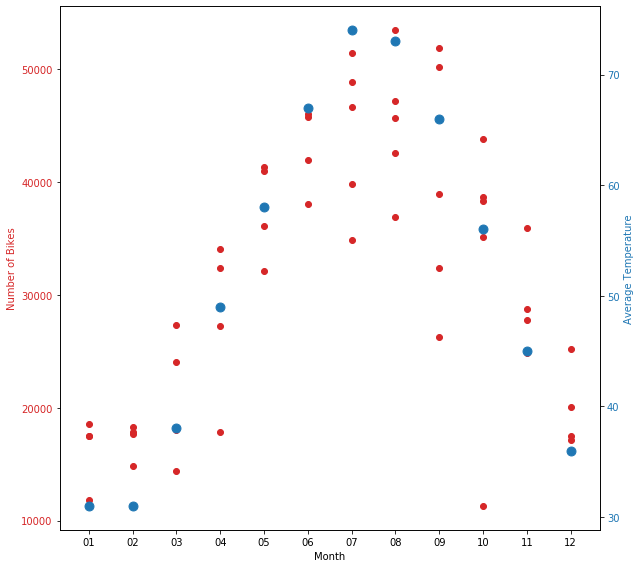

In [36]:
#compare the number of riders per month to the average monthly temperature
months = monthly_bike_count['Month']
bike_count = monthly_bike_count['Count']
avg_temp = monthly_weather['Avg Temp']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Bikes', color=color)
ax1.scatter(months, bike_count, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Average Temperature', color=color)  # we already handled the x-label with ax1
ax2.scatter(monthly_weather['Month Number'], avg_temp, color=color, s=80)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


### There is a clear correlation between monthly temperature and the number of bike riders

## Demographic data of bike commuters in Cambridge

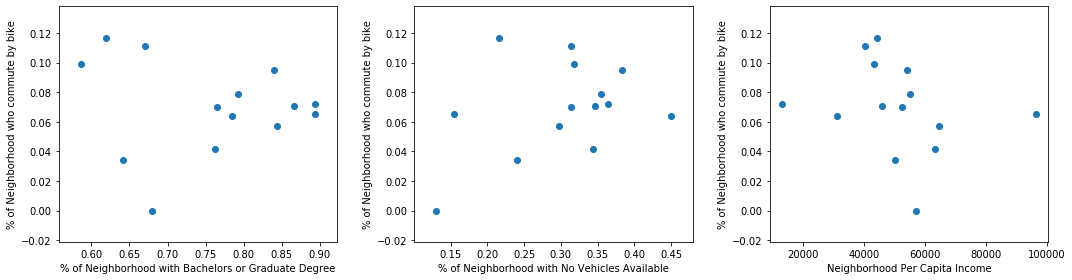

In [173]:
#plot the demographics of bikers in Cambridge

rcParams['figure.figsize'] = 15, 4
x_list = [nbr_data['Bachelors or Graduate Degrees %'], nbr_data['No Vehicles Available %'], nbr_data['Per Capita Income']]
x_label_list = ['% of Neighborhood with Bachelors or Graduate Degree', '% of Neighborhood with No Vehicles Available', 'Neighborhood Per Capita Income']

for i in range(1, 4):
    plt.subplot(1, 3, i)
    x = x_list[(i-1)]
    y = nbr_data['Resident Commute: Bike %']
    plt.scatter(x, y)
    plt.xlabel(x_label_list[i-1])
    plt.ylabel('% of Neighborhood who commute by bike')
    #z = np.polyfit(x, y, 1)
    #p = np.poly1d(z)
    #plt.plot(x,p(x),"r--")

plt.tight_layout()

## A  visual inspection of the effect of different demographic factors (% with bachelor's of graduate degree, % with no vehicle available, per capita income) on the % of neighborhood members who ride their bikes to work does not show strong correlation between any of the different factors. 

# Part 2: Bike safety in Cambridge: Bike Crash Data

In [46]:
#only select crash data that involves a bicyclist
new_bike_crash = new_crash_data.loc[new_crash_data['May involve cyclist'] == 1.0]
new_bike_crash.head()
#create new dataframe from selected, relevant columns of crash database
col_list = ['Date Time','Day of Week', 'Ambient Light', 'Weather Condition 1', 'Road Surface Condition', 'v1 State Code']
new_bike_crash_lim = pd.DataFrame()
for element in col_list:
    new_bike_crash_lim[element] = new_bike_crash[element]
    
new_bike_crash_lim.head(10)

,Date Time,Day of Week,Ambient Light,Weather Condition 1,Road Surface Condition,v1 State Code
1,01/05/2015 09:15:00 AM,Monday,DAYLIGHT,SEVERE CROSSWINDS,DRY,MA
28,04/23/2015 07:20:00 AM,Thursday,DAYLIGHT,CLEAR,DRY,MA
35,06/06/2015 11:39:00 PM,Saturday,DARK - LIGHTED ROADWAY,CLEAR,DRY,MA
39,07/14/2015 08:27:00 PM,Tuesday,DAYLIGHT,CLEAR,DRY,MA
41,07/22/2015 05:24:00 PM,Wednesday,NaN,NaN,NaN,MA
43,08/04/2015 11:20:00 AM,Tuesday,DAYLIGHT,CLEAR,NaN,MA
47,09/07/2015 08:07:00 PM,Monday,DARK - LIGHTED ROADWAY,CLEAR,DRY,NaN
56,11/04/2015 01:15:00 PM,Wednesday,DAYLIGHT,CLEAR,DRY,MA
71,02/18/2016 09:00:00 AM,Thursday,DAYLIGHT,CLEAR,DRY,MA
80,05/18/2016 08:15:00 PM,Wednesday,DUSK,CLEAR,DRY,NaN


In [47]:
# create a function that will give you the bike accidents for a given category
def bike_crash_breakdown(crash_dataframe, category_term):
    crash_dict = {}
    interest_list = crash_dataframe[category_term]
    for i in range(len(interest_list)):
        inter = interest_list.iloc[i]
        if inter in crash_dict:
            crash_dict[inter] += 1
        else:
            crash_dict[inter] = 1
    return crash_dict

In [106]:
# count the number of bike accidents on each day of the week
dow_count = bike_crash_breakdown(new_bike_crash_lim, 'Day of Week')
print(dow_count)

#count the total number of bike crashes
total = 0
for day in dow_count:
    total += dow_count[day]
    
print('Total crashes since 2015:', total)

{'Monday': 106, 'Thursday': 134, 'Saturday': 53, 'Tuesday': 135, 'Wednesday': 153, 'Friday': 104, 'Sunday': 49}
Total crashes since 2015: 734


### More bike accidents happen on weeks day rather than weekends, likely because the majority of bikers are commuting to weekday jobs/school

In [49]:
#function that, give a dictionary with all int values, produces percentages of each value
def dict_percent(int_dict):
    per_list = {}
    total = sum(int_dict.values())
    for item in int_dict:
        curr_val = round(((int_dict[item] / total)*100),2)
        per_list[item] = curr_val
    return per_list

In [50]:
# determine the frequency of bike crashs in different amounts of ambient light. 
crash_light_count = bike_crash_breakdown(new_bike_crash_lim, 'Ambient Light')
print(crash_light_count)
# combine different conditions to create 3 categories: daylight, dark, dusk/dawn
crash_light_count_brf = {}
crash_light_count_brf['dark'] = crash_light_count['DARK - LIGHTED ROADWAY'] + crash_light_count['DARK - UNKNOWN ROADWAY LIGHTING'] + crash_light_count['DARK - ROADWAY NOT LIGHTED']
crash_light_count_brf['dusk'] = crash_light_count['DUSK'] + crash_light_count['DAWN']
crash_light_count_brf['daylight'] = crash_light_count['DAYLIGHT']
print('\n', crash_light_count_brf)


{'DAYLIGHT': 544, 'DARK - LIGHTED ROADWAY': 117, nan: 6, 'DUSK': 48, 'UNKNOWN': 10, 'DARK - UNKNOWN ROADWAY LIGHTING': 2, 'DAWN': 5, 'DARK - ROADWAY NOT LIGHTED': 1, 'OTHER': 1}

 {'dark': 120, 'dusk': 53, 'daylight': 544}


In [51]:
#now determine as a percentage of total bike related crashes
crash_light_percent = dict_percent(crash_light_count_brf)
print("Percent of Crashes in Ambient Light Types")
print(crash_light_percent)

Percent of Crashes in Ambient Light Types
{'dark': 16.74, 'dusk': 7.39, 'daylight': 75.87}


### The majority of bike crashes happen during day light, however, the majority of bike rides also occur during daylight. The next step investigates whether the percentage of accidents that happen at night is proportional to the percentage of bike rides that happen at night. 

In [52]:
broad_bike_count.head()

,DateTime,Day,Date,Time,Total,Westbound,Eastbound
18336,01/01/2016 12:00:00 AM,Friday,01/01/2016,00:00:00,1,1,0
18406,01/01/2016 05:30:00 PM,Friday,01/01/2016,17:30:00,3,2,1
18405,01/01/2016 05:15:00 PM,Friday,01/01/2016,17:15:00,1,1,0
18404,01/01/2016 05:00:00 PM,Friday,01/01/2016,17:00:00,1,1,0
18403,01/01/2016 04:45:00 PM,Friday,01/01/2016,16:45:00,2,2,0


In [53]:
#this function will take input times and return the number of bikers in each time frame
def bike_time_counter(dark_end, morn_dusk_end, daylight_end, eve_dusk_end, dataset, ):
    amb_light_dict = {'dark':0,'dusk':0,'daylight':0}
    all_time = dataset['Time']
    all_count = dataset['Total']
    for i in range(len(all_time)): 
        curr_time =  all_time.iloc[i]
        curr_count = all_count.iloc[i]
        curr_time = int(curr_time[1:3])
        if dark_end > curr_time or curr_time > eve_dusk_end:
            amb_light_dict['dark'] += curr_count
        elif curr_time < morn_dusk_end or curr_time > daylight_end:
            amb_light_dict['dusk'] += curr_count
        else:
            amb_light_dict['daylight'] += curr_count
    return amb_light_dict       

In [54]:
# for a rough estimate of the number of bikers at each type of light: 
# the number of hours of daylight vary throughout the year, the atumn equinox, Sept. 21 will be used as an estimate
# Sept 21, 2019: night 8:18pm to 4:55am dusk/dawn: 4:55am to 6:30am daylight 6:30am to 6:43pm
#daylight time source: https://www.timeanddate.com/sun/usa/boston?month=9


#create dictionary of the bike counts at different ambient lights
broad_bike_light = bike_time_counter(5, 6, 19, 20, broad_bike_count)

#turn counts into %
broad_light_perc = dict_percent(broad_bike_light)

print('percent of biker riders during each light:', broad_light_perc)

percent of biker riders during each light: {'dark': 5.88, 'dusk': 3.79, 'daylight': 90.33}


In [55]:
# calculate the ratio of bikers to crashs in different types of light
norm_light = []
key_list = []
print('% of crashes / % of total riders:')
for key in broad_light_perc:
    key_list.append(key)
    norm_light.append(round(crash_light_percent[key]/broad_light_perc[key] ,2))
    
print(norm_light)
print(key_list)


% of crashes / % of total riders:
[2.85, 1.95, 0.84]
['dark', 'dusk', 'daylight']


## The ratio of number of bike rides the number of crashes involving bicycles is more than 3 times as high at night as it is during the day. This suggests that 

In [56]:
# look at bike crash breakdowns by month of year and normalize by bike riders in each month of year
#the Broadway bike count list starts on 6/24/2015 and ends on 10/27/2019 
#in the full dataset the dates of 6/24 - 10/27 are over represented in the dataset

#to create a dataset where each day of the year is represented fairly, first find i of 6/24/2109
important_list = broad_bike_count['Date']
for i in range(len(important_list)):
    if important_list.iloc[i] == '06/24/2019':
        print('only use data points prior to: ', i)
        stop_val = i
        break 

#create a shortened dataframe to eliminate unequally representation of the different days 
broad_bike_count_cut = broad_bike_count[:stop_val] 

#determine a count for each month of the year
date_data = broad_bike_count_cut['Date']
count_data = broad_bike_count_cut['Total']

month_count_dict = {}

for i in range(len(date_data)):
    curr_date = date_data.iloc[i] 
    curr_month = curr_date[:2]
    curr_count = count_data.iloc[i]
    if curr_month in month_count_dict:
        month_count_dict[curr_month] += curr_count
    else:
        month_count_dict[curr_month] = curr_count
print(month_count_dict)

only use data points prior to:  65263
{'01': 65350, '02': 68771, '03': 83782, '04': 111571, '05': 150639, '06': 136658}


<BarContainer object of 6 artists>

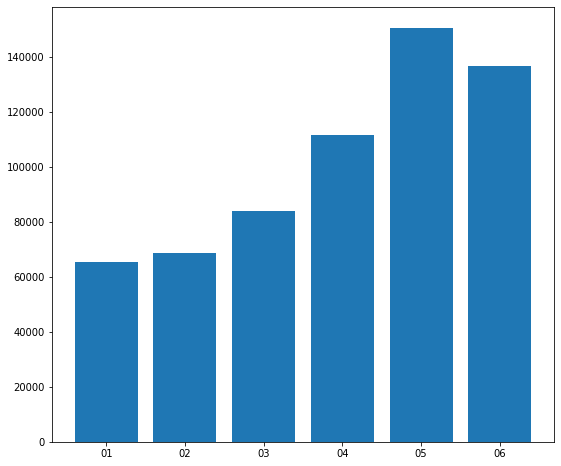

In [57]:
# plot the number of riders per month
plt.bar(month_count_dict.keys(), month_count_dict.values())

In [58]:
monthly_perc_bikers = dict_percent(month_count_dict)
print(monthly_perc_bikers)

{'01': 10.6, '02': 11.15, '03': 13.58, '04': 18.09, '05': 24.42, '06': 22.16}


{'01': 27, '02': 41, '03': 39, '04': 55, '05': 69, '06': 66, '07': 68, '08': 91, '09': 95, '10': 93, '11': 56, '12': 34}


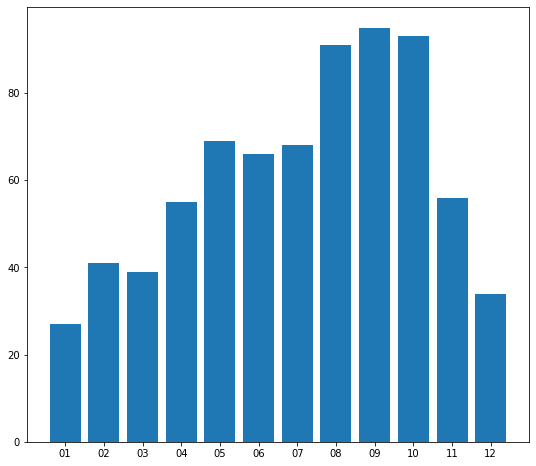

In [59]:
# now determine the number of bicycle crashes each month
crash_dates = new_bike_crash_lim['Date Time']

#python 3 insertion order is guarenteed, so initialize dict with values to maintain correct order
month_crash_count_dict = {'01':0, '02':0, '03':0, '04':0,'05':0, '06':0, '07':0, '08':0, '09':0, '10':0, '11':0,}
for i in range(len(crash_dates)):
    curr_date = crash_dates.iloc[i] 
    curr_month = curr_date[:2]
    if curr_month in month_crash_count_dict:
        month_crash_count_dict[curr_month] += 1
    else:
        month_crash_count_dict[curr_month] = 1
        
print(month_crash_count_dict)


plt.bar(month_crash_count_dict.keys(), month_crash_count_dict.values())
month_perc_crashes = dict_percent(month_crash_count_dict)

In [104]:
#normalize the number of crashes per month by number of bikers per month
norm_crash_month = {}
for i in month_perc_crashes.keys():
    norm_crash_month[i] = round(month_perc_crashes[i] / monthly_perc_bikers[i],2)

#print(norm_crash_month)
norm_crash_month_perc = dict_percent(norm_crash_month)
plt.bar(norm_crash_month_perc.keys(), norm_crash_month_perc.values())
for i, v in enumerate(norm_crash_month_perc.values()):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

KeyError: '07'

In [61]:
# add values to plot if possible

## The months with the highest number of bicycle crashes normalized to the number of bikers are February, September, and October (the highest)

In [95]:
# now examine weather and crashes
crash_weather_count = bike_crash_breakdown(new_bike_crash_lim, 'Weather Condition 1')
print(dict_percent(crash_weather_count))
print('\n')

crash_road_surface_count = bike_crash_breakdown(new_bike_crash_lim, 'Road Surface Condition')
print(dict_percent(crash_road_surface_count))

{'SEVERE CROSSWINDS': 0.14, 'CLEAR': 71.25, nan: 1.09, 'UNKNOWN': 3.27, 'RAIN': 7.77, 'CLOUDY': 15.67, 'SNOW': 0.27, 'SLEET, HAIL, FREEZING RAIN OR DRIZZLE': 0.41, 'OTHER': 0.14}


{'DRY': 79.97, nan: 2.04, 'UNKNOWN': 3.54, 'WET': 12.67, 'ICE': 0.14, 'SNOW': 0.82, 'SAND, MUD, DIRT, OIL, GRAVEL': 0.41, 'OTHER': 0.41}


## Over 70% of crashes involving bicycles occured when the weather was 'clear' and almost 80% of crashes occured when the road way dry

In [103]:
crashes = list(month_perc_crashes.values())
precip = list(monthly_weather['Avg Precipitation'])
month = list(monthly_weather['Month'])
for i in range(len(crashes)):
    print(month[i], crashes[i]/precip[i])

January 1.15
February 1.746875
March 1.3973684210526316
April 2.0243243243243243
May 2.473684210526316
June 1.9127659574468086
July 2.258536585365854
August 3.542857142857143
September 4.3133333333333335
October 2.534
November 2.312121212121212
December 1.0065217391304349


In [105]:
#determine if more out of state cars are involved with bicycle crashes
state_license_dict = bike_crash_breakdown(new_bike_crash_lim, 'v1 State Code')
print(state_license_dict)
state_license_dict['not MA'] = 0

#count the total number of out of state cars involved in bicycle accidents
for state in state_license_dict:
    if state != 'MA' and pd.isnull(state)==False and state != 'not MA':
        state_license_dict['not MA'] += state_license_dict[state]


total_crashes_w_plates = state_license_dict['MA'] + state_license_dict['not MA']
ma_percent = round(state_license_dict['MA'] / total_crashes_w_plates *100 ,1)
not_ma_percent = round(state_license_dict['not MA'] / total_crashes_w_plates* 100, 1)
print('\n')
print(state_license_dict['MA'], 'Massachusetts cars were involved in bicycle crashes', '(', ma_percent, '% of crashes)')
print(state_license_dict['not MA'], 'Out of state cars were involved in bicycle crashes', '(', not_ma_percent, '% of crashes)')

{'MA': 617, nan: 52, 'NH': 11, 'ME': 3, 'NY': 8, 'OH': 2, 'WA': 2, 'FL': 3, 'CT': 8, 'RI': 3, 'OT': 2, 'NJ': 5, 'VT': 3, 'VA': 3, 'AR': 1, 'MD': 2, 'IL': 4, 'ID': 1, 'YT': 1, 'KY': 1, 'PA': 1, 'MN': 1}


617 Massachusetts cars were involved in bicycle crashes ( 90.5 % of crashes)
65 Out of state cars were involved in bicycle crashes ( 9.5 % of crashes)


# interesting that there are a large number of other states, not sure if enough to be statistically signficant, but may be out of state drivers are not used to bikers